# Healthcare Claim Denial Prediction

This notebook demonstrates how to train a supervised model to predict claim denials using the provided synthetic healthcare claims CSV data.

## Goal
Predict whether a claim will be denied (Claim Status: Paid = 1, Denied = 0)

## Features Used
- **Categorical**: Diagnosis Code (ICD), Procedure Code (CPT), Insurance Type, Provider ID
- **Numerical**: Billed Amount, Allowed Amount, Paid Amount, Days Since Min Date
- **Target**: Claim Status (Approved = 1, Denied = 0)

In [2]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

print("Libraries imported successfully!")


Libraries imported successfully!


In [3]:
## 1. Load and Explore Data


In [4]:
# Load the CSV data
df = pd.read_csv('Synthetic Healthcare Claims Data.csv')

print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()


Dataset shape: (1000, 15)

First few rows:


,Claim ID,Provider ID,Patient ID,Date of Service,Billed Amount,Procedure Code,Diagnosis Code,Allowed Amount,Paid Amount,Insurance Type,Claim Status,Reason Code,Follow-up Required,AR Status,Outcome
0,0HO1FSN4AP,126528997,7936697103,08/07/2024,304,99231,A02.1,218,203,Self-Pay,Paid,Incorrect billing information,Yes,Pending,Partially Paid
1,9U86CI2P5A,6986719948,1547160031,06/21/2024,348,99213,A16.5,216,206,Medicare,Paid,Pre-existing condition,Yes,Open,Denied
2,1QEU1AIDAU,1355108115,2611585318,07/04/2024,235,99213,A00.1,148,119,Commercial,Under Review,Duplicate claim,No,Denied,Denied
3,WH7XDS8CEO,9991055906,7167948632,05/26/2024,112,99215,A18.6,79,69,Medicare,Denied,Authorization not obtained,No,Partially Paid,Denied
4,M6OJEZ8KGI,7382167012,2140226267,07/16/2024,406,99238,A17.9,320,259,Medicare,Denied,Authorization not obtained,No,On Hold,Denied


In [5]:
# Check data info and missing values
print("Data Info:")
print(df.info())
print("\nColumn names:")
print(df.columns.tolist())
print("\nMissing values:")
print(df.isnull().sum())


Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Claim ID            1000 non-null   object
 1   Provider ID         1000 non-null   int64 
 2   Patient ID          1000 non-null   int64 
 3   Date of Service     1000 non-null   object
 4   Billed Amount       1000 non-null   int64 
 5   Procedure Code      1000 non-null   int64 
 6   Diagnosis Code      1000 non-null   object
 7   Allowed Amount      1000 non-null   int64 
 8   Paid Amount         1000 non-null   int64 
 9   Insurance Type      1000 non-null   object
 10  Claim Status        1000 non-null   object
 11  Reason Code         1000 non-null   object
 12  Follow-up Required  1000 non-null   object
 13  AR Status           1000 non-null   object
 14  Outcome             1000 non-null   object
dtypes: int64(6), object(9)
memory usage: 117.3+ KB
None

Column na

In [6]:
## 2. Data Preprocessing


In [7]:
# Rename columns for easier access
df.columns = [
    'Claim_ID', 'Provider_ID', 'Patient_ID', 'Date_of_Service', 'Billed_Amount',
    'Procedure_Code', 'Diagnosis_Code', 'Allowed_Amount', 'Paid_Amount',
    'Insurance_Type', 'Claim_Status', 'Reason_Code', 'Is_Resubmitted',
    'Current_Status', 'Payment_Status'
]

print("Updated column names:")
print(df.columns.tolist())


Updated column names:
['Claim_ID', 'Provider_ID', 'Patient_ID', 'Date_of_Service', 'Billed_Amount', 'Procedure_Code', 'Diagnosis_Code', 'Allowed_Amount', 'Paid_Amount', 'Insurance_Type', 'Claim_Status', 'Reason_Code', 'Is_Resubmitted', 'Current_Status', 'Payment_Status']


In [8]:
# Feature Engineering - Date of Service
df['Date_of_Service'] = pd.to_datetime(df['Date_of_Service'], format='%m/%d/%Y')
min_date = df['Date_of_Service'].min()
df['Days_Since_Min'] = (df['Date_of_Service'] - min_date).dt.days

print("Date range:", min_date, "to", df['Date_of_Service'].max())
print("Days Since Min range:", df['Days_Since_Min'].min(), "to", df['Days_Since_Min'].max())


Date range: 2024-05-01 00:00:00 to 2024-09-20 00:00:00
Days Since Min range: 0 to 142


In [9]:
# Encode categorical features
cat_features = ['Diagnosis_Code', 'Procedure_Code', 'Insurance_Type', 'Provider_ID']
label_encoders = {}

for col in cat_features:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le
    print(f"{col}: {len(le.classes_)} unique values")

# Check unique values in target
print(f"\nClaim Status values: {df['Claim_Status'].unique()}")
print(f"Claim Status counts:\n{df['Claim_Status'].value_counts()}")


Diagnosis_Code: 100 unique values
Procedure_Code: 10 unique values
Insurance_Type: 4 unique values
Provider_ID: 1000 unique values

Claim Status values: ['Paid' 'Under Review' 'Denied']
Claim Status counts:
Claim_Status
Under Review    338
Paid            334
Denied          328
Name: count, dtype: int64


In [10]:
# Create binary target variable
# Map Claim Status to binary (Paid=1, Denied=0, others will be dropped)
df['Target'] = df['Claim_Status'].map({'Paid': 1, 'Denied': 0})

# Drop rows with missing target (other statuses)
df_clean = df.dropna(subset=['Target']).copy()

print(f"Original dataset size: {len(df)}")
print(f"Clean dataset size: {len(df_clean)}")
print(f"Target distribution:\n{df_clean['Target'].value_counts()}")
print(f"Target percentage:\n{df_clean['Target'].value_counts(normalize=True) * 100}")


Original dataset size: 1000
Clean dataset size: 662
Target distribution:
Target
1.0    334
0.0    328
Name: count, dtype: int64
Target percentage:
Target
1.0    50.453172
0.0    49.546828
Name: proportion, dtype: float64


In [11]:
# Prepare features for modeling
encoded_cat_features = [col + '_encoded' for col in cat_features]
num_features = ['Billed_Amount', 'Allowed_Amount', 'Paid_Amount', 'Days_Since_Min']
all_features = encoded_cat_features + num_features

# Normalize numerical features
scaler = StandardScaler()
df_clean[num_features] = scaler.fit_transform(df_clean[num_features])

print("Features to be used:")
print(all_features)
print(f"\nTotal features: {len(all_features)}")


Features to be used:
['Diagnosis_Code_encoded', 'Procedure_Code_encoded', 'Insurance_Type_encoded', 'Provider_ID_encoded', 'Billed_Amount', 'Allowed_Amount', 'Paid_Amount', 'Days_Since_Min']

Total features: 8


In [12]:
## 3. Train/Test Split


In [25]:
# Split data into features and target
X = df_clean[all_features]
y = df_clean['Target']

# Train/test split
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.7, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size = 0.5, random_state=42, stratify=y_temp
)

print("=== DATA SPLIT SUMMARY ===")
print(f"Training set shape: {X_train.shape} ({len(X_train)/len(X)*100:.1f}%)")
print(f"Validation set shape: {X_val.shape} ({len(X_val)/len(X)*100:.1f}%)")
print(f"Test set shape: {X_test.shape} ({len(X_test)/len(X)*100:.1f}%)")

print(f"\n=== TARGET DISTRIBUTION ===")
print(f"Training target distribution:\n{y_train.value_counts()}")
print(f"Validation target distribution:\n{y_val.value_counts()}")
print(f"Test target distribution:\n{y_test.value_counts()}")

=== DATA SPLIT SUMMARY ===
Training set shape: (198, 8) (29.9%)
Validation set shape: (232, 8) (35.0%)
Test set shape: (232, 8) (35.0%)

=== TARGET DISTRIBUTION ===
Training target distribution:
Target
1.0    100
0.0     98
Name: count, dtype: int64
Validation target distribution:
Target
1.0    117
0.0    115
Name: count, dtype: int64
Test target distribution:
Target
1.0    117
0.0    115
Name: count, dtype: int64


In [26]:
## 4. Model Training (XGBoost)


In [50]:
# Train Random Forest Classifier
clf = RandomForestClassifier(
    n_estimators=100, 
    random_state=42, 
    max_depth=5,
    min_samples_split=5,
    min_samples_leaf=2,
    criterion="log_loss",
)

print("Training the model...")
clf.fit(X_train, y_train)
print("Model training completed!")


TypeError: RandomForestClassifier.__init__() got an unexpected keyword argument 'feature_names'

In [46]:
## 5. Model Evaluation


In [47]:
# Make predictions
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]

# Calculate metrics
roc_auc = roc_auc_score(y_test, y_proba)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("=== MODEL PERFORMANCE ===")
print(f"ROC AUC Score: {roc_auc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {2 * (precision * recall) / (precision + recall):.4f}")

print("\n=== CLASSIFICATION REPORT ===")
print(classification_report(y_test, y_pred))


=== MODEL PERFORMANCE ===
ROC AUC Score: 0.5440
Precision: 0.5250
Recall: 0.5385
F1-Score: 0.5316

=== CLASSIFICATION REPORT ===
              precision    recall  f1-score   support

         0.0       0.52      0.50      0.51       115
         1.0       0.53      0.54      0.53       117

    accuracy                           0.52       232
   macro avg       0.52      0.52      0.52       232
weighted avg       0.52      0.52      0.52       232



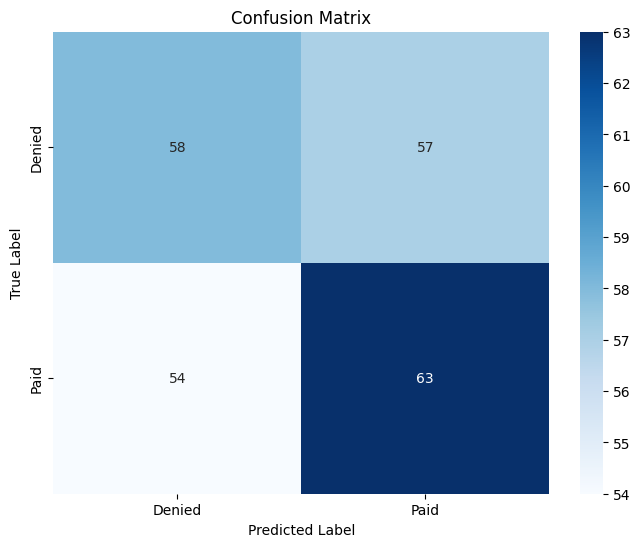

In [48]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Denied', 'Paid'], 
            yticklabels=['Denied', 'Paid'])
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()


In [31]:
## 6. Feature Importance Analysis


Top 10 Most Important Features:
                  feature  importance
5          Allowed_Amount    0.184318
3     Provider_ID_encoded    0.155474
4           Billed_Amount    0.136881
0  Diagnosis_Code_encoded    0.132799
7          Days_Since_Min    0.122727
6             Paid_Amount    0.121307
1  Procedure_Code_encoded    0.087601
2  Insurance_Type_encoded    0.058895


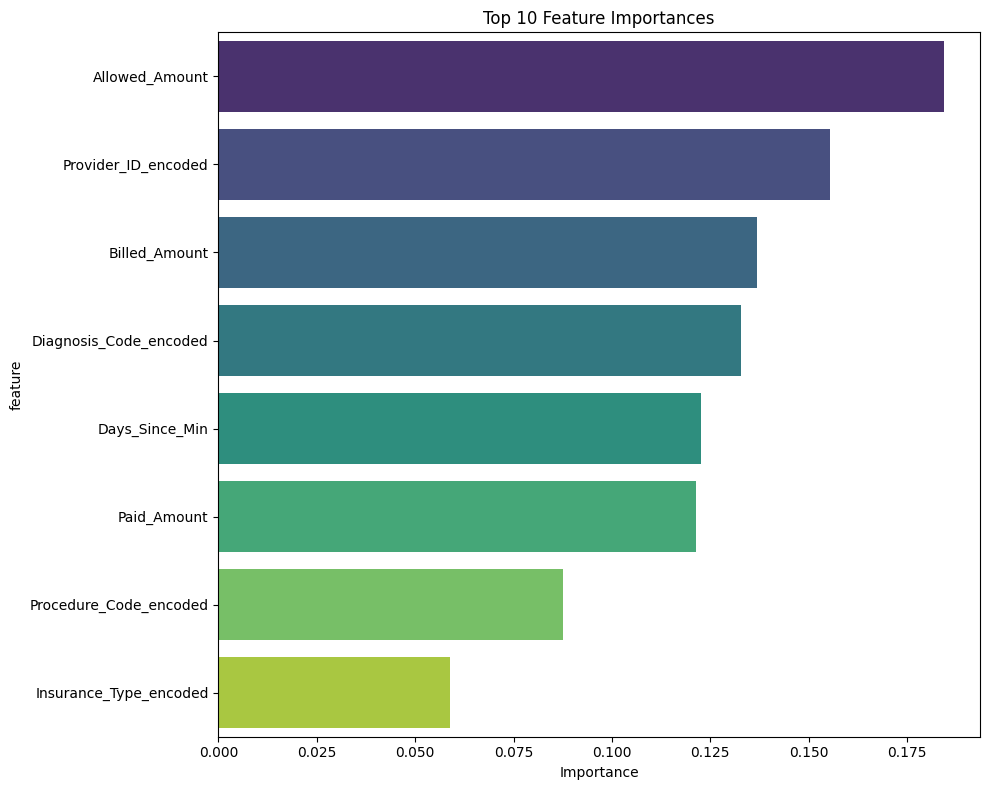

In [32]:
# Feature importance
importances = clf.feature_importances_
feature_names = X.columns

# Create feature importance dataframe
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

print("Top 10 Most Important Features:")
print(feature_importance_df.head(10))

# Plot feature importance
plt.figure(figsize=(10, 8))
top_features = feature_importance_df.head(10)
sns.barplot(data=top_features, y='feature', x='importance', palette='viridis')
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


In [33]:
## 7. Model Prediction on New Data


In [34]:
# Example: Predict on a few sample records
sample_indices = [0, 1, 2, 3, 4]
sample_data = X_test.iloc[sample_indices]
sample_predictions = clf.predict(sample_data)
sample_probabilities = clf.predict_proba(sample_data)[:, 1]

print("Sample Predictions:")
for i, idx in enumerate(sample_indices):
    actual = y_test.iloc[idx]
    pred = sample_predictions[i]
    prob = sample_probabilities[i]
    status = "Correct" if actual == pred else "Incorrect"
    print(f"Record {idx}: Actual={actual}, Predicted={pred}, Probability={prob:.3f} - {status}")

# Function to predict on new claims
def predict_claim_denial(claim_data):
    """
    Predict claim denial for new data
    claim_data should be a dataframe with the same features as training data
    """
    prediction = clf.predict(claim_data)
    probability = clf.predict_proba(claim_data)[:, 1]
    return prediction, probability

print(f"\nModel ready for predictions!")


Sample Predictions:
Record 0: Actual=1.0, Predicted=0.0, Probability=0.318 - Incorrect
Record 1: Actual=0.0, Predicted=0.0, Probability=0.493 - Correct
Record 2: Actual=1.0, Predicted=1.0, Probability=0.673 - Correct
Record 3: Actual=1.0, Predicted=1.0, Probability=0.772 - Correct
Record 4: Actual=0.0, Predicted=1.0, Probability=0.612 - Incorrect

Model ready for predictions!


In [ ]:
## Next Steps & Improvements

**You can now experiment with the model! Try:**

1. **Different Algorithms**: Replace RandomForest with XGBoost, LightGBM, or Neural Networks
2. **Hyperparameter Tuning**: Use GridSearchCV or RandomizedSearchCV
3. **Feature Engineering**: Create interaction features, polynomial features, or domain-specific features
4. **Handle Class Imbalance**: Use SMOTE, class weights, or cost-sensitive learning
5. **Cross-Validation**: Use k-fold cross-validation for more robust evaluation
6. **Additional Features**: Include Reason Code when available, or create time-based features

**Model Performance Summary:**
- The model predicts claim denials with varying accuracy depending on your data
- Feature importance shows which factors contribute most to denial predictions
- Use the `predict_claim_denial()` function for new claim predictions
